In [1]:
# Imports and declarations
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["image.cmap"] = "binary_r"
sys.path.append("../../semi-supervised")

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
cuda = torch.cuda.is_available()

# Deep Generative Model

In this notebook we will run the Deep Generative Model as described in (Kingma 2014). The model builds on a standard variational autoencoder by adding label information during the inference. The main gist of the model is that we utilise label information when available, and marginalise over all labels when unavailable.

Here we use a limited subset of MNIST to make training faster.

In [2]:
from data.limitedmnist import LimitedMNIST
from utils import generate_label, onehot

batch_size = 32

labels = [0, 1, 2, 3, 4]
n = len(labels)

# Load in data
mnist_lab = LimitedMNIST('./', train=True, transform=torch.bernoulli, target_transform=onehot(n), digits=labels, fraction=0.005)
mnist_ulab = LimitedMNIST('./', train=True, transform=torch.bernoulli, target_transform=onehot(n), digits=labels, fraction=1.0)
mnist_val = LimitedMNIST('./', train=False, transform=torch.bernoulli, target_transform=onehot(n), digits=labels)

# Unlabelled data
unlabelled = torch.utils.data.DataLoader(mnist_ulab, batch_size=100, shuffle=True, num_workers=2)

# Validation data
validation = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True, num_workers=2)

# Labelled data
labelled = torch.utils.data.DataLoader(mnist_lab, batch_size=100, shuffle=True, num_workers=2)

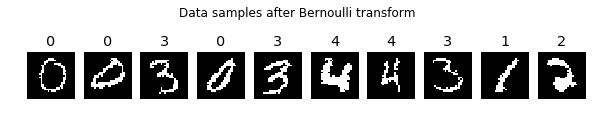

In [3]:
f, axarr = plt.subplots(1, 10, figsize=(10, 2))
images, labels = next(iter(labelled))
_, labels = torch.max(labels, 1)

for i in range(10):
    axarr[i].imshow(images[i].numpy().reshape(28, 28))
    title = labels[i] if labels[i] < 5 else "Unknown"
    axarr[i].set_title(title)
    axarr[i].axis("off")
    
f.suptitle("Data samples after Bernoulli transform")
plt.show()

We instantiate a Deep Generative Model by specifing the ratio between labelled and unlabelled data. We use variational inference to fit data to the model, like for the VAE. In this case, we also have label information so we use `VariationalInferenceWithLabels`. This objective is based on the ELBO objective described in (Kingma 2014).


$$\log p_{\theta}(x, y) \geq \mathbb{E}_{q_{\phi}(z|x, y)} [ \log p_{\theta}(x|y, z) + \log p_{\theta}(y) + \log \frac{p(z)}{q_{\phi}(z|x, y)} ] = - \mathcal{L}(x, y)$$

Where the first term in the equation describes the likelihood function. The second can be viewed as a *prior* over the labels $y$, while the third part is just the KL-divergence we have already seen in VAEs. In this example, we choose a `discrete_uniform_prior` over the labels.

In [4]:
from models import DeepGenerativeModel
from inference.loss import VariationalInferenceWithLabels, kl_divergence_normal, discrete_uniform_prior

# Numerical stability
epsilon = 1e-7

# DGM with a single hidden layer in both the encoder and decoder
model = DeepGenerativeModel(ratio=len(mnist_ulab)/len(mnist_lab), dims=[28 * 28, n, 16, [128, 64]])

if cuda: model.cuda()

def binary_cross_entropy(r, x):
    return torch.sum((x * torch.log(r + epsilon) + (1 - x) * torch.log((1 - r) + epsilon)), dim=-1)

def cross_entropy(y, logits):
    return -torch.sum(y * torch.log(logits + epsilon), dim=1)
    
objective = VariationalInferenceWithLabels(binary_cross_entropy, kl_divergence_normal, discrete_uniform_prior)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model

DeepGenerativeModel (
  (encoder): Encoder (
    (hidden): ModuleList (
      (0): Linear (128 -> 128)
      (1): Linear (128 -> 64)
    )
    (sample): StochasticGaussian (
      (mu): Linear (64 -> 16)
      (log_var): Linear (64 -> 16)
    )
  )
  (decoder): Decoder (
    (hidden): ModuleList (
      (0): Linear (16 -> 64)
      (1): Linear (64 -> 128)
    )
    (reconstruction): Linear (128 -> 784)
    (output_activation): Sigmoid ()
  )
  (classifier): Classifier (
    (dense): Linear (784 -> 128)
    (logits): Linear (128 -> 5)
  )
  (transform_x_to_h): Linear (784 -> 128)
  (transform_y_to_h): Linear (5 -> 128)
  (transform_y_to_z): Linear (5 -> 16)
)

Training the model is a bit more complicated than for the standard VAE. We need to define two different cases based on whether the incoming data has labels or not. We use the definition for the ELBO given in the previous equation:

$$- \mathcal{L}(x, y) = \mathbb{E}_{q_{\phi}(z|x, y)} [ \log p_{\theta}(x|y, z) + \log p_{\theta}(y) + \log \frac{p(z)}{q_{\phi}(z|x, y)} ]$$

If labels are given, we calculate the ELBO along with the cross entropy.

$$\mathcal{L}(x, y) + \alpha \cdot \mathbb{E}_{\tilde{p}_l(x, y)}[- \log q_{\phi}(y|x)]$$

However, if no labels are given, we must instead sum over all of the labels. In order to keep the equations balanced, we are required to calculate the entropy.

$$\sum_y q_{\phi}(y|x)(- \mathcal{L}(x, y)) + \mathcal{H}(q_{\phi}(y|x)) = -\mathcal{U}(x)$$

In [8]:
class DGMTrainer():
    """
    Class for training Deep Generative Models.
    :param model: Object of class `DeepGenerativeModel`
    :param objective: Loss function for labelled data, e.g. `VariationalInferenceWithLabels`
    :param optimizer: A PyTorch-enabled optimizer
    :param cuda: Optional parameter whether to use CUDA acceleration
    """
    def __init__(self, model, objective, optimizer, cuda=False):
        self.model = model
        self.objective = objective
        self.optimizer = optimizer
        self.cuda = cuda

    def calculate_loss(self, x, y=None):
        """
        Given a semi-supervised problem (x, y) pair where y
        is only occasionally observed, calculates the
        associated loss.
        :param x: Features
        :param y: Labels (optional)
        :returns L_alpha if labelled, U if unlabelled.
        """
        is_unlabelled = True if y is None else False

        x = Variable(x)
        logits = self.model(x)

        # If the data is unlabelled, sum over all classes
        if is_unlabelled:
            [batch_size, *_] = x.size()
            x = x.repeat(n, 1)
            y = torch.cat([generate_label(batch_size, i, n) for i in range(n)])

        y = Variable(y.type(torch.FloatTensor))
        
        if self.cuda:
            x = x.cuda()
            y = y.cuda()

        # Compute lower bound (the same as -L)
        reconstruction, _, z = self.model(x, y)
        ELBO = self.objective(reconstruction, x, y, [z])

        # In the unlabelled case calculate the entropy H and return U
        if is_unlabelled:
            ELBO = ELBO.view(logits.size())
            loss = torch.sum(torch.mul(logits, ELBO - torch.log(logits)), -1)
            loss = -torch.mean(loss)
        # In the case of labels add cross entropy and return L_alpha
        else:
            loss = ELBO + self.model.beta * -cross_entropy(y, logits)
            loss = -torch.mean(loss)

        return loss
    
    def train(self, labelled, unlabelled):
        """
        Trains a DGM model based on some data.
        :param labelled: Labelled data loader
        :param inlabelled: Unlabelled data loader
        :return L, U: Final loss values.
        """
        for (x, y), (u, _) in zip(labelled, unlabelled):
            L = self.calculate_loss(x, y)
            U = self.calculate_loss(u, None)

            J = L + U

            J.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return L, U

## Visualisation

Here you can optionally enable the use of `visdom` to visualise the training process.

In [9]:
use_visdom = True

if use_visdom:
    import visdom
    vis = visdom.Visdom()

class Visualiser():
    def __init__(self):
        self.loss = vis.line(X=np.array([0]), Y=np.array([0]), opts=dict(title="Training Loss", xlabel="Epoch"))
        self.acc  = vis.line(X=np.array([0]), Y=np.array([0]), opts=dict(title="Accuracy", xlabel="Epoch"))

    def update_loss(self, L, U):
        vis.updateTrace(X=np.array([epoch]), Y=L.data.numpy(), win=self.loss, name="Labelled")
        vis.updateTrace(X=np.array([epoch]), Y=U.data.numpy(), win=self.loss, name="Unlabelled")
        
    def update_accuracy(self, model):
        accuracy = []
        for x, y in validation:
            _, prediction = torch.max(model.classifier(Variable(x)), 1)
            _, y = torch.max(y, 1)

            accuracy += [torch.mean((prediction.data == y).float())]

        vis.updateTrace(X=np.array([epoch]), Y=np.array([np.mean(accuracy)]), win=self.acc)
        
    def update_images(self, model):
        x, y = next(iter(validation))
        input = Variable(x[:5])
        label = Variable(y[:5].type(torch.FloatTensor))
        x_hat, *_ = model(input, label)
        images = x_hat.data.numpy().reshape(-1, 1, 28, 28)

        vis.images(images, opts=dict(width=5*64, height=64, caption="Sample epoch {}".format(epoch)))

Controlling which dataloaders to use, we gather the losses into a single combined loss that we can backpropagate.

$$\mathcal{J}^{\alpha} = \mathcal{L}^{\alpha} + \mathcal{U}$$

In [10]:
from torch.autograd import Variable

trainer = DGMTrainer(model, objective, optimizer)
visual = Visualiser()

for epoch in range(1001):
    L, U = trainer.train(labelled, unlabelled)
        
    if use_visdom:
        # Plot the last L and U of the epoch
        visual.update_loss(L, U)
        visual.update_accuracy(model)

        if epoch % 100 == 0:
            visual.update_images(model)

After performing training, your plots should look something like this:
    
![](../images/visdom-dgm.png)

In [37]:
z = Variable(torch.randn(1, 16))
y = Variable(generate_label(1, 2, 5))

r = model.sample(z, y)

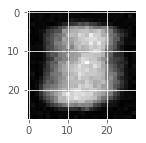

In [38]:
f = plt.figure(figsize=(2, 2))
plt.imshow(r.view(28, 28).data.numpy())